# Reading O5 Catalog

In [1]:
import os
import subprocess
import yaml

from astropy.io import fits
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import random
from scipy.stats import norm
import glob
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set()

# Opening a file

In [112]:
fp = "../GammaCatalog_O5/"

In [113]:
f = glob.glob(fp + "*.fits")[55]

In [114]:
g = fits.open(f)

In [115]:
g.info()

Filename: ../GammaCatalog_O5/catO5_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  ENERGIES      1 BinTableHDU     13   41R x 1C   [E]   
  2  TIMES         1 BinTableHDU     17   70R x 2C   [E, E]   
  3  SPECTRA       1 BinTableHDU     92   70R x 41C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [116]:
g[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
MERGERID= '' / identif. num. for a given realization                            
LONG    =                5.923 / longitude                                      
LAT     =                1.053 / latitude                                       
EISO    =             2.86E+49 / Eiso prompt emission of the GRB (erg)          
DISTANCE=             263000.0 / distance (kpc)                                 
ANGLE   =               63.682 / viewing angle (deg)                            
AUTHOR  = '' / Lara                                                             
PROJECT = '' / CTA-GW                                                           
HISTORY Created Sept 2021. B

In [117]:
d = g[3].data

In [118]:
start_times = [i[0] for i in g[2].data]

def get_spec(time_bin, data):
    
    return [i[time_bin] for i in data]

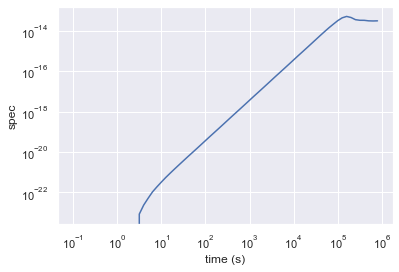

In [119]:
plt.loglog(start_times, get_spec(0, g[3].data))
plt.xlabel("time (s)")
plt.ylabel("spec")
plt.show()

# Extracting info from files

In [120]:
g[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
MERGERID= '' / identif. num. for a given realization                            
LONG    =                5.923 / longitude                                      
LAT     =                1.053 / latitude                                       
EISO    =             2.86E+49 / Eiso prompt emission of the GRB (erg)          
DISTANCE=             263000.0 / distance (kpc)                                 
ANGLE   =               63.682 / viewing angle (deg)                            
AUTHOR  = '' / Lara                                                             
PROJECT = '' / CTA-GW                                                           
HISTORY Created Sept 2021. B

In [121]:
p = Path(f)

In [122]:
p.stem.strip("catO?5_")

'0'

In [123]:
info = {}

for gw in glob.glob(fp + "*.fits"):
    
    try:
        gw_id = int(Path(gw).stem[6:])
    except ValueError as e:
        
        print(gw)
        raise e
    
    g = fits.open(gw)
    
    h = g[0].header
    
    info[gw_id] = {
        "event_id": gw_id,
        "long": h["LONG"],
        "lat": h["LAT"],
        "eiso": h["EISO"],
        "dist": h["DISTANCE"],
        "angle": h["ANGLE"],
    }
    
    g.close()

In [124]:
events = pd.DataFrame.from_dict(info, orient="index")

## Read in times

In [125]:
times = pd.read_csv(
    "../GammaCatalog_O5/times.txt", 
    sep="\t", 
    names=["event_id", "time_utc"], 
    parse_dates=["time_utc"],
    skiprows=1
) 

In [126]:
events = pd.merge(events, times, on="event_id").set_index("event_id").sort_index()

In [127]:
events.to_csv("../GammaCatalog_O5/events.csv")

In [128]:
events

,long,lat,eiso,dist,angle,time_utc
event_id,,,,,,
0,5.923,1.053,2.860000e+49,263000.0,63.682,2012-06-29 01:24:30.971
1,1.666,-0.917,3.080000e+50,1280000.0,28.794,2011-10-28 00:12:50.906
2,1.653,-0.551,5.730000e+47,909000.0,59.989,2012-01-16 13:16:18.682
3,0.749,1.098,6.660000e+48,1290000.0,55.033,2012-09-10 11:15:45.680
4,3.623,0.586,1.950000e+49,349000.0,28.554,2012-01-03 04:56:29.356
...,...,...,...,...,...,...
2302,3.211,-0.385,1.320000e+51,971000.0,61.195,2011-09-28 05:31:34.925
2303,4.022,1.049,6.180000e+47,548000.0,62.712,2012-07-05 22:51:02.557
2304,0.156,1.260,1.550000e+48,424000.0,32.844,2012-08-03 17:57:40.139


# Interacting with GW Toy

In [3]:
import sys
sys.path.append("..")

In [4]:
from gravitational_wave_toy import GWToyV5 as GW

In [73]:
sens = GW.Sensitivity(
    "/Users/jarred/Documents/grbsens/notebooks/grbsens_output/no_ebl/grbsens_results/grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
    min_energy=0.3,     # as determined by the range of the IRFs
    max_energy=10000,
)

In [173]:
grb = GW.GRB("../GammaCatalog_O5/catO5_100.fits")

In [174]:
grb.observe(sensitivity=sens, start_time=3600, target_precision=0.1)

{'filepath': '../GammaCatalog_O5/catO5_100.fits',
 'min_energy': 0.3,
 'max_energy': 10000,
 'seen': False,
 'obs_time': -1,
 'start_time': 3600,
 'end_time': -1,
 'error_message': '',
 'long': 6.155,
 'lat': -1.0,
 'eiso': 5.73e+47,
 'dist': 1240000.0,
 'angle': 54.081}

In [32]:
# OR

GW.observe_grb(
    "../GammaCatalog_O5/catO5_100.fits",
    sensitivity=s,
    start_time=7200,
)

{'filepath': '../GammaCatalog_O5/catO5_1.fits',
 'min_energy': 0.3,
 'max_energy': 10000,
 'seen': True,
 'obs_time': 6,
 'start_time': 7200,
 'end_time': 7206,
 'error_message': '',
 'long': 1.666,
 'lat': -0.917,
 'eiso': 3.08e+50,
 'dist': 1280000.0,
 'angle': 28.794}